In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

import torch
import pyro
from pyro import distributions as dist
from pyro.infer.mcmc import NUTS, MCMC
from pyro.infer.abstract_infer import EmpiricalMarginal, TracePredictive

In [2]:
data = pd.read_csv("../input/data3a.csv")

In [3]:
data.head()

,y,x,f
0,6,8.31,C
1,6,9.44,C
2,6,9.50,C
3,12,9.07,C
4,10,10.16,C


In [4]:
data["f_num"] = data.f.replace("C", 0).replace("T", 1)

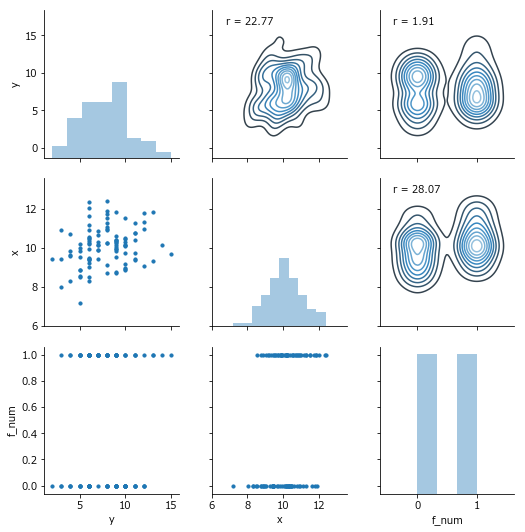

In [5]:
def corrfunc(x, y, **kws):
    r, _ = stats.pearsonr(x, y)
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r*100),
                xy=(.1, .9), xycoords=ax.transAxes)
g = sns.PairGrid(data, palette=["red"])
g.map_lower(plt.scatter, s=10)
g.map_diag(sns.distplot, kde=False)
g.map_upper(sns.kdeplot, cmap="Blues_d")
g.map_upper(corrfunc)

## 問題設定
体サイズ(x)と処理の違い(f)から種子数(y)を推定する

## モデル式
$$\lambda_i = b_1 + b_2 x + b_3 f$$
$$y_i \sim Poisson(lambda_i)$$

In [6]:
def model(x, f, y):
    b1 = pyro.sample("b1", dist.Normal(0, 10.))
    b2 = pyro.sample("b2", dist.Normal(0, 10.))
    b3 = pyro.sample("b3", dist.Normal(0, 10.))
    
    lambda_ = torch.exp(b1 + b2 * x + b3 * f)
    with pyro.plate("data", len(x)):
        pyro.sample("obs", dist.Poisson(lambda_), obs=y)

In [7]:
x = torch.tensor(data.x)
f = torch.tensor(data.f_num).float()
y = torch.tensor(data.y).float()

In [8]:
hmc_kernel = NUTS(model, adapt_step_size=True, jit_compile=True, ignore_jit_warnings=True)
mcmc_posterior = MCMC(hmc_kernel, num_samples=1000, num_chains=4, warmup_steps=1000).run(x, f, y)

In [9]:
sites = ["b1", "b2", "b3"]
mcmc_marginal = EmpiricalMarginal(mcmc_posterior, sites)._get_samples_and_weights()[0]

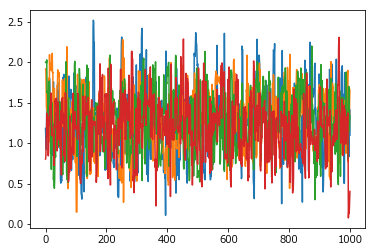

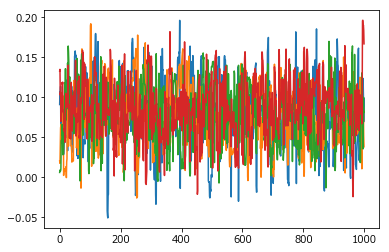

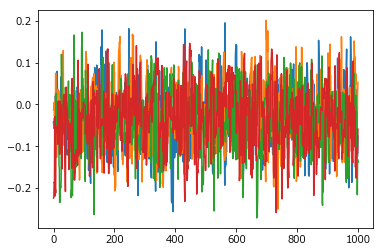

In [10]:
for j in range(3):
    plt.figure()
    for i in range(4):
        plt.plot(range(1000), mcmc_marginal[i, :, j].numpy())

In [11]:
df_samples = pd.DataFrame(mcmc_marginal.reshape(-1, len(sites)).numpy(), columns=sites)

In [12]:
result = df_samples.quantile([0.025, 0.25, 0.5, 0.75, 0.975]).T
result["mean"] = df_samples.mean(0)
result

,0.025,0.25,0.5,0.75,0.975,mean
b1,0.554657,1.008462,1.255709,1.511222,1.987065,1.260076
b2,0.008030,0.055183,0.080775,0.105880,0.150751,0.080146
b3,-0.175356,-0.080736,-0.031867,0.016030,0.110188,-0.032628


In [14]:
def predict_model(x, f):
    b1 = pyro.sample("b1", dist.Normal(0, 10.))
    b2 = pyro.sample("b2", dist.Normal(0, 10.))
    b3 = pyro.sample("b3", dist.Normal(0, 10.))
    
    lambda_ = torch.exp(b1 + b2 * x + b3 * f)
    pyro.sample("y", dist.Poisson(lambda_))
mcmc_predictive = TracePredictive(predict_model, mcmc_posterior, num_samples=1000).run(x, f)
y_samples = EmpiricalMarginal(mcmc_predictive, "y")._get_samples_and_weights()[0]

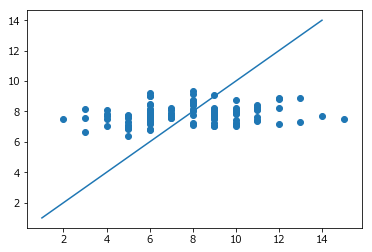

In [18]:
plt.plot(range(1, 15), range(1, 15))
plt.scatter(data.y, y_samples.mean(0).numpy())